In [1]:
import argparse
import torch
from scipy.linalg import sqrtm

import wandb
import numpy as np
from dassl.utils import setup_logger, set_random_seed, collect_env_info
from dassl.config import get_cfg_default
from dassl.engine import build_trainer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture

In [2]:
def reset_cfg(cfg, args):
    if args.root:
        cfg.DATASET.ROOT = args.root

    if args.output_dir:
        cfg.OUTPUT_DIR = args.output_dir

    if args.resume:
        cfg.RESUME = args.resume

    if args.seed:
        cfg.SEED = args.seed

    if args.source_domains:
        cfg.DATASET.SOURCE_DOMAINS = args.source_domains

    if args.target_domains:
        cfg.DATASET.TARGET_DOMAINS = args.target_domains

    if args.transforms:
        cfg.INPUT.TRANSFORMS = args.transforms

    if args.trainer:
        cfg.TRAINER.NAME = args.trainer

    if args.backbone:
        cfg.MODEL.BACKBONE.NAME = args.backbone

    if args.head:
        cfg.MODEL.HEAD.NAME = args.head

    #if args.uncertainty:
    cfg.MODEL.UNCERTAINTY = args.uncertainty

    #if args.pos:
    cfg.MODEL.POS = args.pos
    # cfg.USE_CUDA = False
    
def setup_cfg(args):
    cfg = get_cfg_default()
    reset_cfg(cfg, args)
    if args.dataset_config_file:
        cfg.merge_from_file(args.dataset_config_file)
    if args.config_file:
        cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    return cfg

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--root', type=str, default='./DATA', help='path to dataset')
parser.add_argument(
    '--output-dir', type=str, default='../output/dg/pacs/baseline/explore/art_painting_cartoon-sketch', help='output directory'
)
parser.add_argument(
    '--resume',
    type=str,
    default='',
    help='checkpoint directory (from which the training resumes)'
)
parser.add_argument(
    '--seed',
    type=int,
    default=1,
    help='only positive value enables a fixed seed'
)
parser.add_argument(
    '--source-domains',
    type=str,
    nargs='+',
    default='art_painting'.split(),
    help='source domains for DA/DG'
)
parser.add_argument(
    '--target-domains',
    type=str,
    nargs='+',
    default=['sketch'],
    help='target domains for DA/DG'
)
parser.add_argument(
    '--transforms', type=str, nargs='+', help='data augmentation methods'
)
parser.add_argument(
    '--config-file', type=str, default='../configs/trainers/dg/vanilla/pacs.yaml', help='path to config file'
)
parser.add_argument(
    '--dataset-config-file',
    type=str,
    default='../configs/datasets/dg/pacs.yaml',
    help='path to config file for dataset setup'
)
parser.add_argument(
    '--trainer', type=str, default='RIDG', help='name of trainer'
)
parser.add_argument(
    '--backbone', type=str, default='', help='name of CNN backbone'
)
parser.add_argument('--head', type=str, default='', help='name of head')
parser.add_argument(
    '--eval-only', action='store_true', help='evaluation only'
)
parser.add_argument(
    '--model-dir',
    type=str,
    default='',
    help='load model from this directory for eval-only mode'
)
parser.add_argument(
    '--load-epoch',
    type=int,
    help='load model weights at this epoch for evaluation'
)
parser.add_argument(
    '--no-train', action='store_true', help='do not call trainer.train()'
)
parser.add_argument(
    'opts',
    default=None,
    nargs=argparse.REMAINDER,
    help='modify config options using the command-line'
)
parser.add_argument('--uncertainty', default=0.0, type=float)
parser.add_argument('--pos', nargs='+', type=int, default=[],
                    help='pos for uncertainty')
parser.add_argument('--wandb', default=0, type=int, help='visualize on Wandb')
parser.add_argument('--option', default='', type=str, help='additional options')
parser.add_argument('--update_interval', default=20, type=int, help='update cluster interval')

args = parser.parse_args('')

In [4]:
cfg = setup_cfg(args)
if args.wandb:
    if 'u' in cfg.MODEL.BACKBONE.NAME:
        job_type = 'DSU'
    elif 'c' in cfg.MODEL.BACKBONE.NAME:
        job_type = 'ConstStyle'
    else:
        job_type = 'Baseline'
    if cfg.MODEL.BACKBONE.PRETRAINED:
        job_type += '-pretrained'
        
    tracker = wandb.init(
        project = 'StyleDG',
        entity = 'aiotlab',
        config = args,
        group = f'{cfg.DATASET.NAME}',
        name = f'train={cfg.DATASET.SOURCE_DOMAINS}_test={cfg.DATASET.TARGET_DOMAINS}_type={args.option}',
        job_type = job_type
    )
    args.tracker = tracker

if cfg.SEED >= 0:
    print('Setting fixed seed: {}'.format(cfg.SEED))
    set_random_seed(cfg.SEED)
setup_logger(cfg.OUTPUT_DIR)

if torch.cuda.is_available() and cfg.USE_CUDA:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

trainer = build_trainer(cfg, args)

Setting fixed seed: 1
Loading trainer: RIDG
<class 'dassl.engine.dg.ridg.RIDG'>
Loading dataset: PACS
Train dataset statistics| Domain [0] - count [1840] | Class: [0 1 2 3 4 5 6] - count [341 229 256 165 180 265 404]
Test dataset statistics| Domain [10] - count [3928] | Class: [0 1 2 3 4 5 6] - count [771 740 753 608 816  80 160]
Building transform_train
+ resize to 224x224
+ random flip
+ random translation
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building transform_test
+ resize to 224x224
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
***** Dataset statistics *****
  Dataset: PACS
  Source domains: ['art_painting']
  Target domains: ['sketch']
  # classes: 7
  # train_x: 1,840
  # val: 208
  # test: 3,928
Building model
Backbone: resnet18
# params: 11,180,103
Loading evaluator: Classification


In [5]:
trainer.load_model(cfg.OUTPUT_DIR, epoch=56)

Loading weights to model from "../output/dg/pacs/baseline/explore/art_painting_cartoon-sketch/model/model.pth.tar-56" (epoch = 56)
Do evaluation on test set
=> result
* total: 3,928
* correct: 2,649
* current accuracy: 67.44%
* best accuracy: 67.44%
* error: 32.56%


In [6]:
trainer.test()

In [7]:
train_loader = trainer.train_loader_x
test_loader = trainer.test_loader

In [8]:
id_domains = []
id_labels = []
id_feats = []
id_style_feats = []

for idx, batch in enumerate(trainer.train_loader_x):
    images, label = trainer.parse_batch_train(batch)
    domain = batch['domain']
    class_feat = trainer.model(images)
    style_feat = trainer.model.backbone.stylemaps(images)
    id_domains.extend(domain.numpy())
    id_labels.extend(label.detach().cpu().numpy())
    id_feats.extend(class_feat.detach().cpu().numpy())
    id_style_feats.extend(style_feat.detach().cpu().numpy())

In [9]:
od_domains = []
od_labels = []
od_feats = []
od_style_feats = []

for idx, batch in enumerate(trainer.test_loader):
    images, label = trainer.parse_batch_test(batch)
    domain = batch['domain']
    class_feat = trainer.model(images)
    style_feat = trainer.model.backbone.stylemaps(images)
    od_domains.extend(domain.numpy())
    od_labels.extend(label.detach().cpu().numpy())
    od_feats.extend(class_feat.detach().cpu().numpy())
    od_style_feats.extend(style_feat.detach().cpu().numpy())

In [10]:
len(id_domains), len(od_domains)

(1792, 3928)

In [11]:
id_feats = np.array(id_feats)
od_feats = np.array(od_feats)
total_domains = np.hstack((id_domains, od_domains))
id_labels = np.array(id_labels)
od_labels = np.array(od_labels)
id_style_feats = np.array(id_style_feats)
od_style_feats = np.array(od_style_feats)

In [12]:
id_feats.shape, od_feats.shape

((1792, 7), (3928, 7))

In [13]:
# for i in range(7):
#     class_feats = od_feats[od_labels == i]
#     mean_class_score = np.mean(class_feats, axis=0)
#     classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6']
#     plt.bar(classes, mean_class_score)
#     plt.title(f'Mean prediction of class {i}\n {mean_class_score}')
#     plt.show()

In [14]:
id_domains = []
id_labels = []
id_feats = []

for idx, batch in enumerate(trainer.train_loader_x):
    images, label = trainer.parse_batch_train(batch)
    domain = batch['domain']
    class_feat = trainer.model.backbone(images)
    id_domains.extend(domain.numpy())
    id_labels.extend(label.detach().cpu().numpy())
    id_feats.extend(class_feat.detach().cpu().numpy())

In [15]:
od_domains = []
od_labels = []
od_feats = []

for idx, batch in enumerate(trainer.test_loader):
    images, label = trainer.parse_batch_test(batch)
    domain = batch['domain']
    class_feat = trainer.model.backbone(images)
    od_domains.extend(domain.numpy())
    od_labels.extend(label.detach().cpu().numpy())
    od_feats.extend(class_feat.detach().cpu().numpy())

In [16]:
id_feats = np.array(id_feats)
od_feats = np.array(od_feats)
total_domains = np.hstack((id_domains, od_domains))
id_labels = np.array(id_labels)
od_labels = np.array(od_labels)

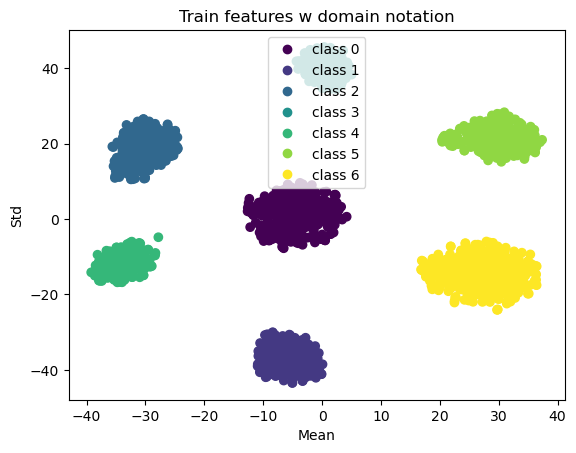

In [17]:
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(id_feats)
classes = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=id_labels)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('Train features w domain notation')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

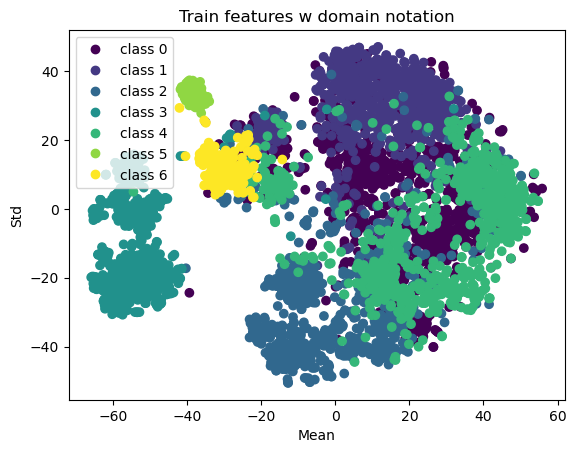

In [18]:
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(od_feats)
classes = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=od_labels)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('Train features w domain notation')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

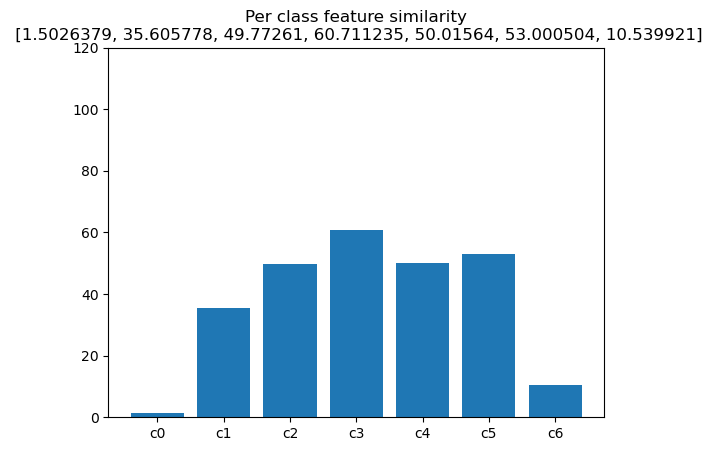

In [19]:
gap_list = []
for i in range(7):
    train_feats = id_feats[id_labels == i]
    test_feats = od_feats[od_labels == i]
    mean_train = np.mean(train_feats, axis=0)
    mean_test = np.mean(test_feats, axis=0)
    feat_gap = np.abs((mean_train - mean_test).sum())
    gap_list.append(feat_gap)
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6']
plt.bar(classes, gap_list)
plt.title(f'Per class feature similarity\n {gap_list}')
plt.ylim(0, 120)
plt.show()

In [20]:
id_mean = id_style_feats.mean(axis=(2, 3))
id_std = id_style_feats.var(axis=(2, 3))
id_std = np.sqrt(id_std + 1e-6)
id_style = np.hstack((id_mean, id_std))

od_mean = od_style_feats.mean(axis=(2, 3))
od_std = od_style_feats.var(axis=(2, 3))
od_std = np.sqrt(od_std + 1e-6)
od_style = np.hstack((od_mean, od_std))

In [21]:
def wasserstein_distance_multivariate(mean1, cov1, mean2, cov2):
    mean_diff = mean1 - mean2
    mean_distance = np.dot(mean_diff, mean_diff)
    sqrt_cov1 = sqrtm(cov1)
    if np.iscomplexobj(sqrt_cov1):
        sqrt_cov1 = sqrt_cov1.real
    # Compute the term involving the covariance matrices
    cov_sqrt_product = sqrtm(sqrt_cov1 @ cov2 @ sqrt_cov1)
    if np.iscomplexobj(cov_sqrt_product):
        cov_sqrt_product = cov_sqrt_product.real

    cov_term = np.trace(cov1 + cov2 - 2 * cov_sqrt_product)
    wasserstein_distance = np.sqrt(mean_distance + cov_term)
    return wasserstein_distance

In [22]:
id_bayes_cluster = BayesianGaussianMixture(n_components=1, covariance_type='full', init_params='k-means++', max_iter=200)
id_bayes_cluster.fit(id_style)

od_bayes_cluster = BayesianGaussianMixture(n_components=1, covariance_type='full', init_params='k-means++', max_iter=200)
od_bayes_cluster.fit(od_style)

BayesianGaussianMixture(init_params='k-means++', max_iter=200)

In [23]:
wasserstein_distance_multivariate(id_bayes_cluster.means_[0], id_bayes_cluster.covariances_[0], od_bayes_cluster.means_[0], od_bayes_cluster.covariances_[0])

1.915155965491278

In [24]:
total_style = np.vstack((id_style, od_style))

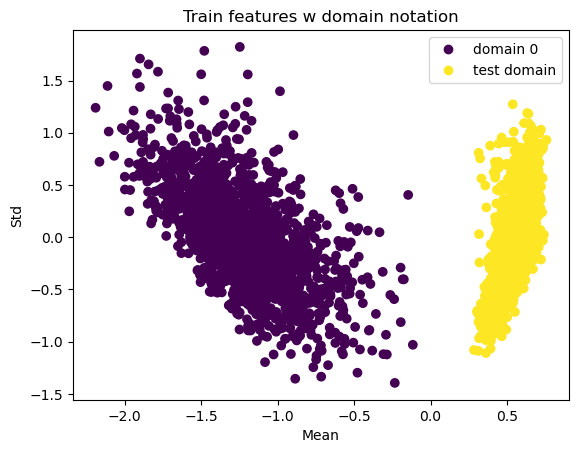

In [25]:
# tsne = TSNE(n_components=2)
# transformed_data = tsne.fit_transform(total_style)
# scaler = StandardScaler()
# scaled_style = scaler.fit_transform(total_style)
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(total_style)
domains = ['domain 0', 'test domain']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=total_domains)
plt.legend(handles=scatter.legend_elements()[0], labels=domains)
plt.title('Train features w domain notation')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()